# Jellyfish species recognition using CNN

Importing all the data. Ignoring the suggested train/test/validation split to avoid overfitting on a particular dataset.

In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import os
import re

image_paths = []
for dirname, _, filenames in os.walk('/kaggle/input/jellyfish-types'):
    for filename in filenames:
        image_paths.append(os.path.join(dirname, filename))

match_type = re.compile('.*/([^/]*)_jellyfish.*')
types = [match_type.match(path).group(1) for path in image_paths]
one_hot = pd.get_dummies(types, dtype=int)
labels = one_hot.columns
y = one_hot.to_numpy()

def load_image(path):
    content = tf.io.read_file(path)
    image = tf.io.decode_jpeg(content)
    scaled = tf.image.resize(image, size = (128, 128)) # To make sure all images have same size
    return tf.cast(scaled, tf.float32) / 255

X = np.array([load_image(path) for path in image_paths])
X.shape

(1879, 128, 128, 3)

The network tends to overfit with only 1879 samples. In order to get more samples, some variations are added to the train and validation data. This helped. The random brightness seemed to do the most difference.

Adding some variation with random noise add is worth a consideration.

In [11]:
def add_variations(X, y):
    def variations(image):
        flip_lr = tf.image.flip_left_right(image)
        flip_ud = tf.image.flip_up_down(image)
        img180 = tf.image.flip_up_down(flip_lr)
        return [image, flip_lr, flip_ud, img180, 
                tf.image.random_brightness(image, .1),
                tf.image.random_contrast(image, 0.01, .1)]
    
    x_element_shape = X.shape[1:]
    y_element_shape = y.shape[1:]
    
    X = np.array([variations(x) for x in X])
    y = np.array([np.full((X.shape[1], *v.shape), v) for v in y])
    
    return X.reshape([-1, *x_element_shape]), y.reshape(-1, *y_element_shape)

    
X_, X_test, y_, y_test = train_test_split(X, y, random_state=504)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, random_state=504)
X_train, y_train = add_variations(X_train, y_train)

## The Network

Trying out GeLU because some research teams have had success with it. It looked like it was having unstable gradients, so everything gets batch normalization.

Note, how the encoder network is halving image (feature map) side length and increasing feature maps at same rate. (Which halves number of neurons.) At the end, the encoding is a 256-dimensional vector, which seems like a lot, but worked best with the amount of data we have.

The decoder starts with a dense layer to get the right number of dimensions, then scales 8x8 feature maps to a 128x128 image one double up at a time.

In [31]:
activation = 'gelu'

encoder = tf.keras.models.Sequential([
    layers.Conv2D(3, 3, activation=activation, padding='same'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(16, 5, activation=activation, padding='same'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, activation=activation, padding='same'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, activation=activation, padding='same'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(128, 3, activation=activation, padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, activation=activation, padding='same'),
    layers.GlobalAvgPool2D(),
])
decoder = tf.keras.Sequential([
    layers.Input(256),
    layers.BatchNormalization(),
    layers.Dense(8 * 8 * 16),
    layers.Reshape((8, 8, 16)),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation=activation),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation=activation),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(8, 3, strides=2, padding="same", activation=activation),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(3, 3, strides=2, padding="same", activation=activation)
])
cnn = tf.keras.models.Sequential([
    layers.Input(X_train.shape[1:]),
    encoder,
    decoder
])


In [32]:
tf.random.set_seed(504)

cnn.compile(loss = 'mse', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01))

es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 40, restore_best_weights=True)
adjust_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=10, factor=0.5, min_lr=1e-4)

history = cnn.fit(X_train, X_train, 
                  epochs = 250, 
                  validation_data = (X_valid, X_valid),
                  callbacks = [adjust_lr])

Epoch 1/250
198/198 [==============================] - 12s 21ms/step - loss: 0.0446 - val_loss: 0.0356 - lr: 0.0100
Epoch 2/250
198/198 [==============================] - 4s 18ms/step - loss: 0.0224 - val_loss: 0.0429 - lr: 0.0100
Epoch 3/250
198/198 [==============================] - 4s 18ms/step - loss: 0.0177 - val_loss: 0.0320 - lr: 0.0100
Epoch 4/250
198/198 [==============================] - 4s 18ms/step - loss: 0.0159 - val_loss: 0.0271 - lr: 0.0100
Epoch 5/250
198/198 [==============================] - 4s 18ms/step - loss: 0.0155 - val_loss: 0.0190 - lr: 0.0100
Epoch 6/250
198/198 [==============================] - 4s 18ms/step - loss: 0.0144 - val_loss: 0.0322 - lr: 0.0100
Epoch 7/250
198/198 [==============================] - 4s 18ms/step - loss: 0.0129 - val_loss: 0.0319 - lr: 0.0100
Epoch 8/250
198/198 [==============================] - 4s 18ms/step - loss: 0.0123 - val_loss: 0.0210 - lr: 0.0100
Epoch 9/250
198/198 [==============================] - 4s 19ms/step - loss: 0.0

## The outcome

This is wild and overfitting in the beginning, but then it starts to settle down. Something to remember when configuring early stopping.

This looks like a very low MSE, but all values are between 0 and 1, so it's only somewhat good.

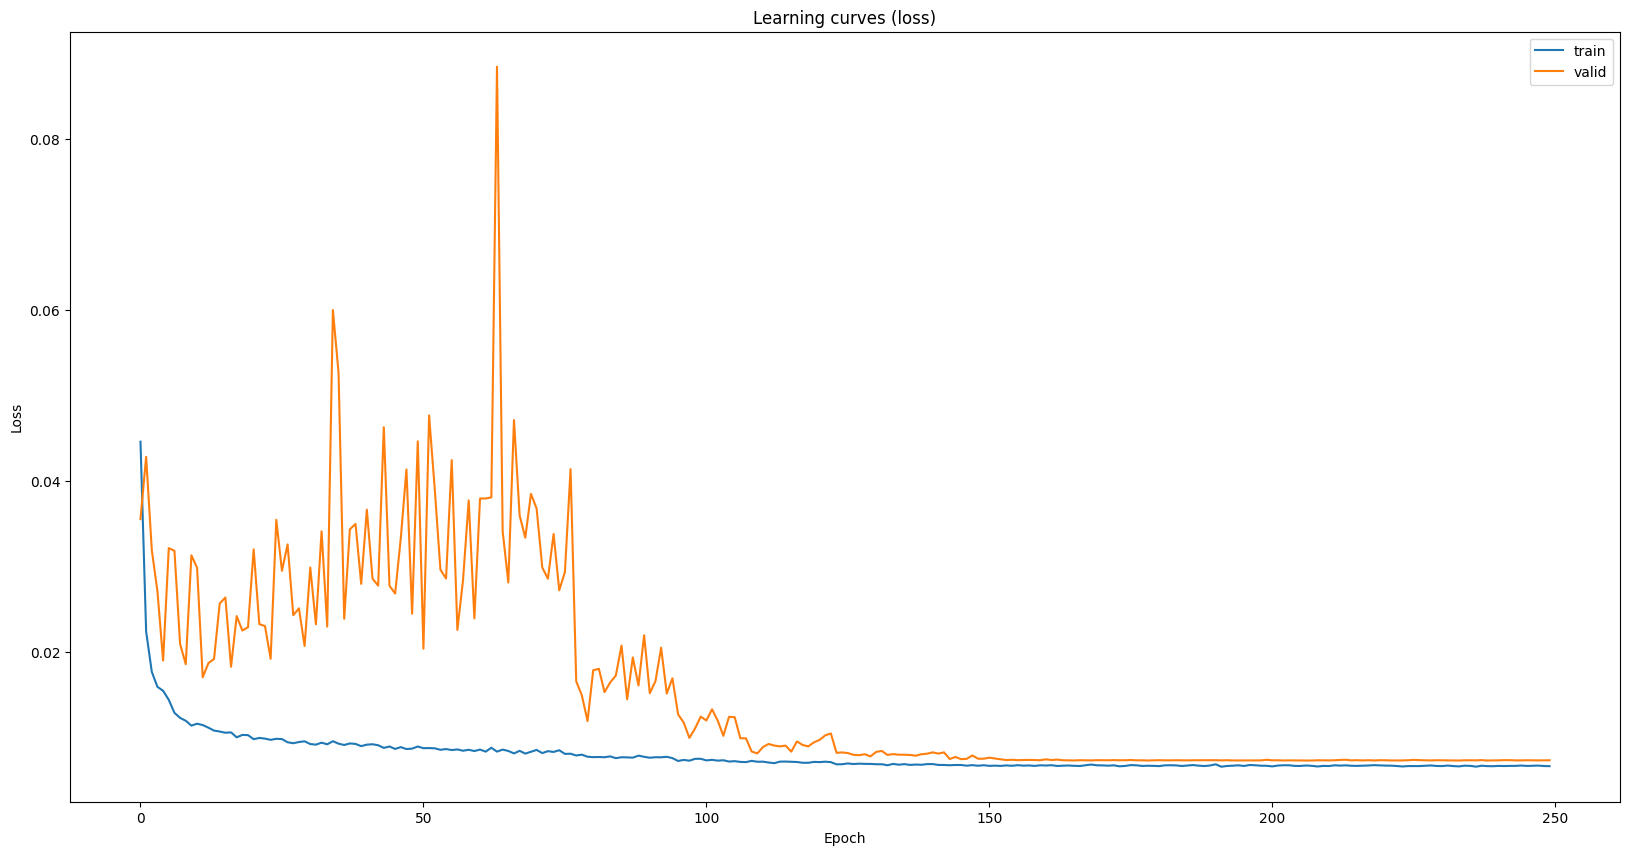

In [33]:
figure = plt.figure(figsize=(20, 10))
ax = figure.add_subplot(1, 1, 1, title='Learning curves (loss)')
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.plot(history.history['loss'], label = 'train')
ax.plot(history.history['val_loss'], label = 'valid')
ax.legend()

plt.show()

This shows how well it did on the training set. First the real images, then the reconstruction.

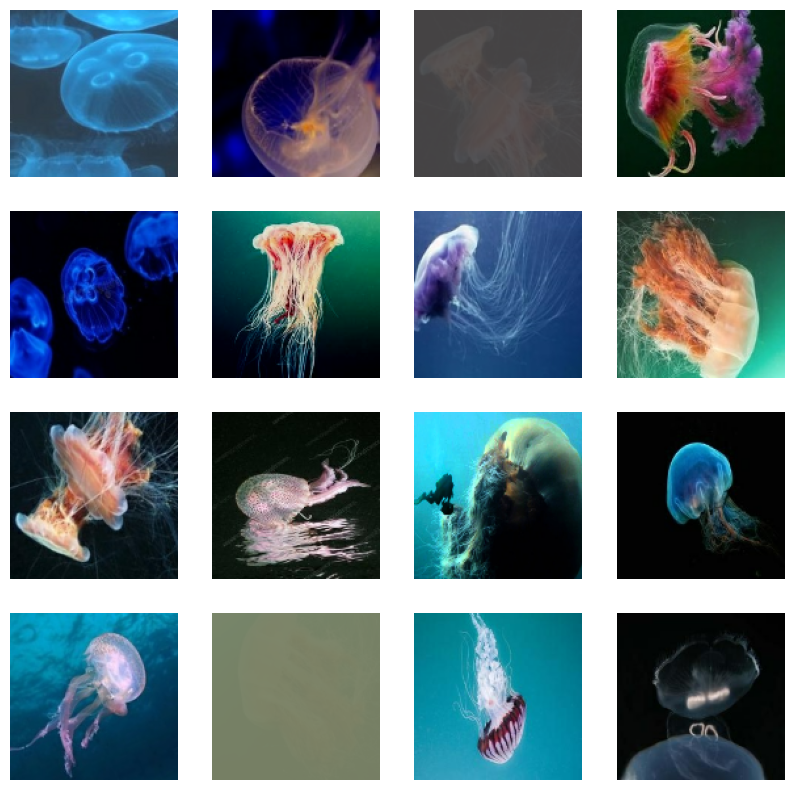

In [34]:
random_jellyfish = [X_train[np.random.randint(0, len(X_test)), :, :, :] for i in range(16)]

fig, axes = plt.subplots(4, 4, figsize=(10,10))

for index, kernel in enumerate(random_jellyfish):
    ax=axes[index // 4][index % 4]
    ax.axis('off')
    ax.imshow(kernel)

1/1 [==============================] - 0s 326ms/step


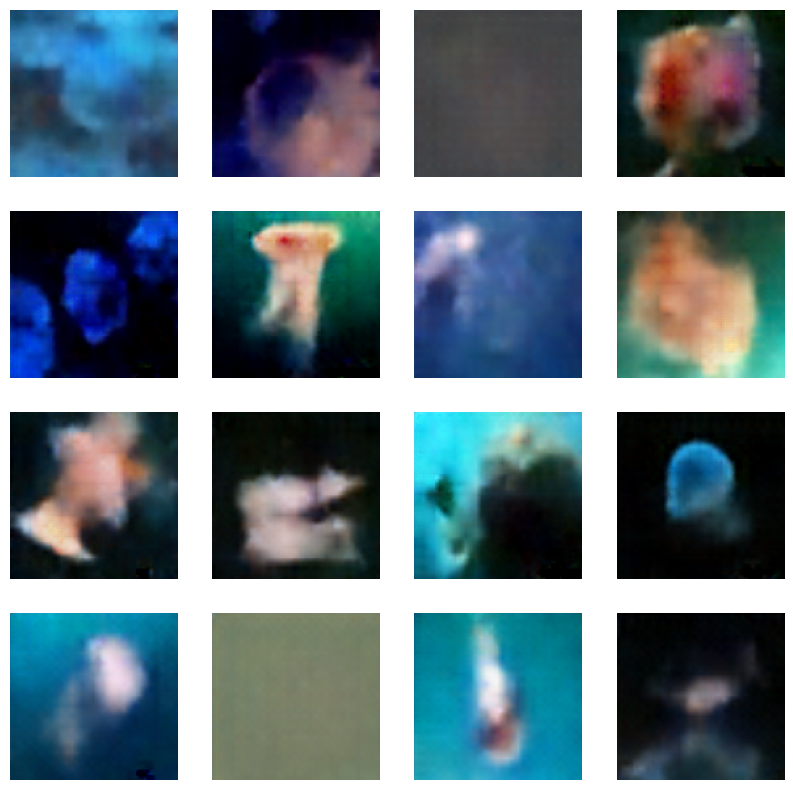

In [35]:
reconstructed_jellyfish = cnn.predict(np.array(random_jellyfish))

fig, axes = plt.subplots(4, 4, figsize=(10,10))

for index, kernel in enumerate(reconstructed_jellyfish):
    ax=axes[index // 4][index % 4]
    ax.axis('off')
    ax.imshow(kernel)

Test set looks similar, which makes sense since it didn't overfit.

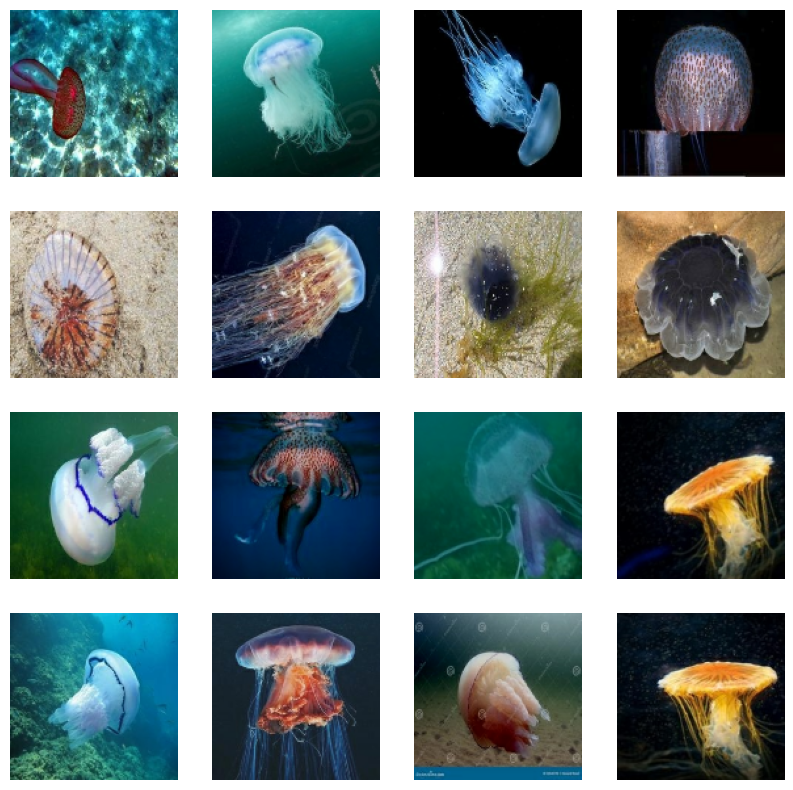

In [36]:
random_jellyfish = [X_test[np.random.randint(0, len(X_test)), :, :, :] for i in range(16)]

fig, axes = plt.subplots(4, 4, figsize=(10,10))

for index, kernel in enumerate(random_jellyfish):
    ax=axes[index // 4][index % 4]
    ax.axis('off')
    ax.imshow(kernel)

1/1 [==============================] - 0s 24ms/step


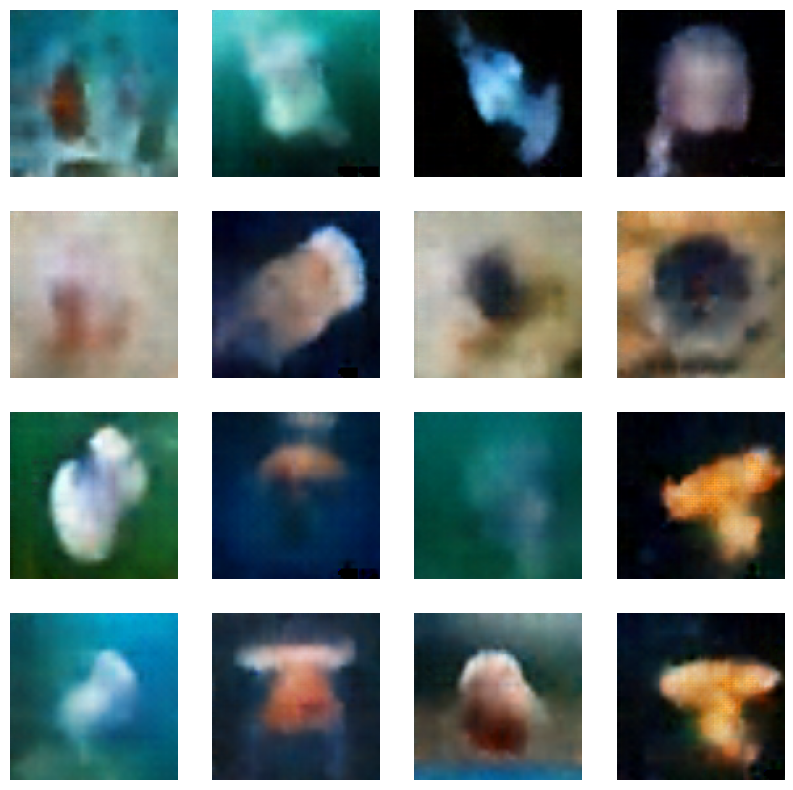

In [37]:
reconstructed_jellyfish = cnn.predict(np.array(random_jellyfish))

fig, axes = plt.subplots(4, 4, figsize=(10,10))

for index, kernel in enumerate(reconstructed_jellyfish):
    ax=axes[index // 4][index % 4]
    ax.axis('off')
    ax.imshow(kernel)